## Import Statements

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pytz
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from geopy import distance
import datetime
import tilemapbase
from copy import deepcopy

## Data Loading

In [3]:
source = 'combined'
sensor = 'pm25'
res_time = '1H'

In [4]:
filepath_root = '/scratch/ab9738/pollution_with_sensors/'
filepath_data_kai = filepath_root+'data/kaiterra/kaiterra_fieldeggid_{}_current_panel.csv'.format(res_time)
filepath_data_gov = filepath_root+'data/govdata/govdata_{}_current.csv'.format(res_time)
filepath_locs_kai = filepath_root+'data/kaiterra/kaiterra_locations.csv'
filepath_locs_gov = filepath_root+'data/govdata/govdata_locations.csv'

locs_kai = pd.read_csv(filepath_locs_kai, index_col=[0])
locs_kai['Type'] = 'Kaiterra'
locs_gov = pd.read_csv(filepath_locs_gov, index_col=[0])
locs_gov['Type'] = 'Govt'
locs = pd.merge(locs_kai, locs_gov, how='outer',\
                on=['Monitor ID', 'Latitude', 'Longitude', 'Location', 'Type'], copy=False)
data_kai = pd.read_csv(filepath_data_kai, index_col=[0,1], parse_dates=True)[sensor]
data_gov = pd.read_csv(filepath_data_gov, index_col=[0,1], parse_dates=True)[sensor]
data = pd.concat([data_kai, data_gov], axis=0, copy=False)

start_dt = data.index.levels[1][0]
end_dt = data.index.levels[1][-1]

if start_dt.tzname != 'IST':
        if start_dt.tzinfo is None:
            start_dt = start_dt.tz_localize('UTC')
        start_dt = start_dt.tz_convert(pytz.FixedOffset(330))
    
if end_dt.tzname != 'IST':
    if end_dt.tzinfo is None: 
        end_dt = end_dt.tz_localize('UTC')
    end_dt = end_dt.tz_convert(pytz.FixedOffset(330))

# now, filter through the start and end dates
data.sort_index(inplace=True)
data = data.loc[(slice(None), slice(start_dt, end_dt))]

# Data Analysis

## Time Dimension


In [5]:
df = data.unstack(level=0)
distances = pd.read_csv('/scratch/ab9738/pollution_with_sensors/data/combined_distances.csv', index_col=[0])
distances = distances.loc[df.columns, df.columns]
distances[distances == 0] = np.nan

In [6]:
diff_list = []
for col in list(df.columns):
    arr = df[col].dropna().to_numpy()
    diff_arr = np.zeros(len(arr)-1)
    for i in range(len(arr)-1):
        diff_arr[i] = abs(arr[i+1]-arr[i])
    diff_list.append(diff_arr)
    
diff = np.concatenate(diff_list)

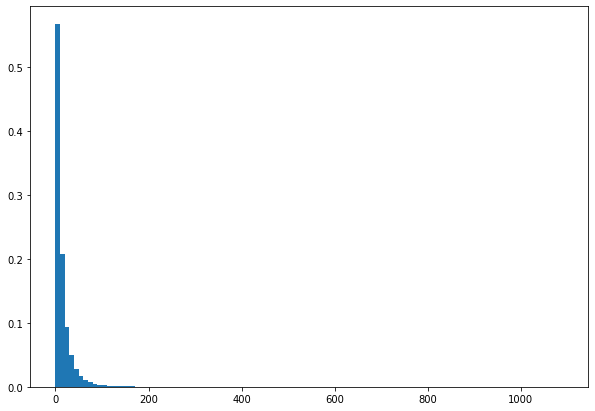

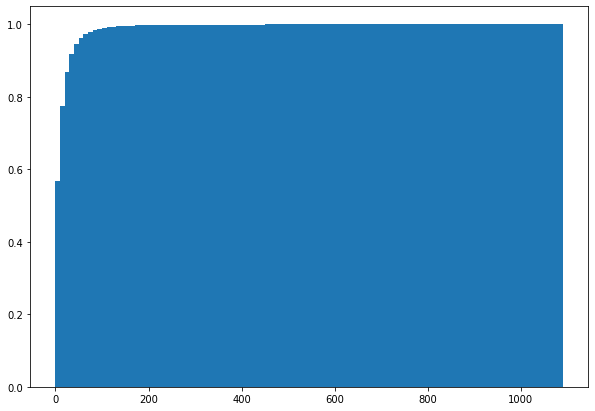

In [7]:
fig, ax = plt.subplots(figsize=(10,7))
stats = plt.hist(diff, weights=np.ones(len(diff))/len(diff), bins=range(int(min(diff)),int(max(diff)) + 10, 10),\
                 cumulative=False)
fig, ax = plt.subplots(figsize=(10,7))
_ = plt.hist(diff, weights=np.ones(len(diff))/len(diff), bins=range(int(min(diff)),int(max(diff)) + 10, 10),\
                 cumulative=True)

In [8]:
stats[0][:15].sum()

0.9956563187837433

In [9]:
(stats[0]*(stats[1]+5)[:-1]).sum()

16.095476870325673

In [10]:
mean = []
for col in list(df.columns):
    mean.append(df[col].dropna().mean())
sum(mean)/len(mean)

98.04156504073684

The value of 50 can be considered covering most of the contiguous jumps that happen. Beyond the point 100, jumps are considered rare (less than 5%). We can take 100 as the threshold for defining a hotspot.

## Space Dimension

In [11]:
nn_dict = {}
for col in df.columns:
    dist_df = distances.loc[col].sort_values().dropna()
    nn_dict[col] = dist_df

In [12]:
diff_list = []
for index in list(df.index):
    for col in df.columns:
        diff_val = abs(df.loc[index][col] - df.loc[index][nn_dict[col].index[0]])
        diff_list.append(diff_val)
diff = np.array(diff_list)
diff = diff[~np.isnan(diff)]

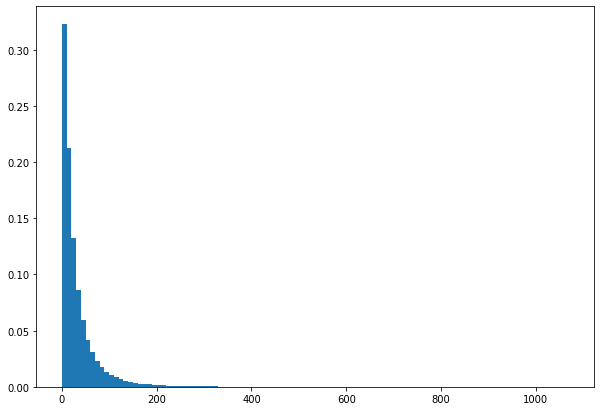

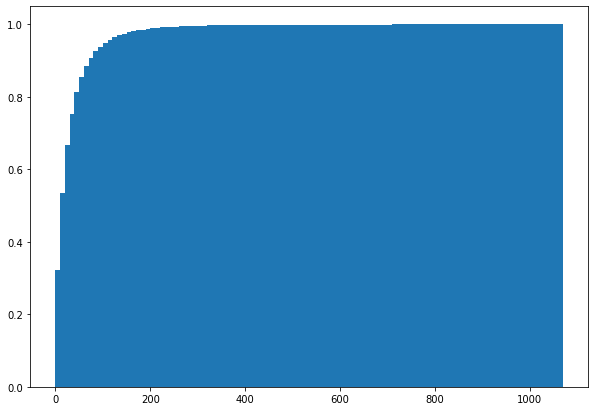

In [13]:
fig, ax = plt.subplots(figsize=(10,7))
stats = plt.hist(diff, weights=np.ones(len(diff))/len(diff), bins=range(int(min(diff)),int(max(diff)) + 10, 10),\
                 cumulative=False)
fig, ax = plt.subplots(figsize=(10,7))
_ = plt.hist(diff, weights=np.ones(len(diff))/len(diff), bins=range(int(min(diff)),int(max(diff)) + 10, 10),\
                 cumulative=True)

In [14]:
stats[0][:15].sum()

0.9746605239672196

In [15]:
(stats[0]*(stats[1]+5)[:-1]).sum()

32.84582518854537